# [IAPR 2019:][iapr2019] Lab 2 ‒  Object description

**Author:** first name and last name  
**Due date:** 19.04.2019

[iapr2019]: https://github.com/LTS5/iapr-2019

## Extract relevant data
We first need to extract the `lab-02-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [2]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

In [3]:
import cv2 as cv
from skimage import measure, transform, morphology
import numpy as np
from scipy import ndimage

## Description
In the `lab-02-data/` folder, you will find 28x28 grey-scale pictures of handwritten "0" and "1".
These digits have been extracted from MNIST dataset (http://yann.lecun.com/exdb/mnist/).

Your goal is to extract, from each of those images, a 2-dimensional feature vector (i.e. 2 features) and to plot them all on a 2D graph.
If you have chosen good features, the vectors of the "0"'s should nicely cluster in one part of the plane and those of the "1"'s in another.

Please try first the Fourier Descriptors.
You can make several attempts: e.g. with and without invariance to rotation, translation, scaling, etc.
You can also for instance rotate the images and assess the invariance in rotation.

**Note:** for the Fourier descriptors, the u_k signal has to be constructed by following the contour point after point.
Some pre-processing (image binarization, possibly some Mathematical Morphology) might be useful.

Then feel free to try other features, the more you try, the better it will be (for you).

### 1.1 Data visualization

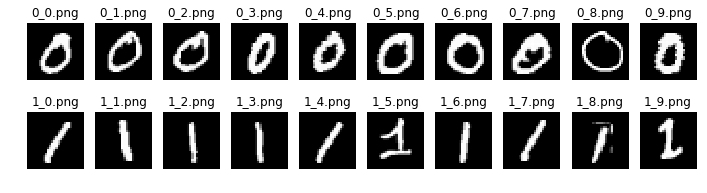

In [4]:
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline

# Load images
data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
#  Load zeros
zeros_path = os.path.join(data_base_path, data_folder, '0')
zeros_names = [nm for nm in os.listdir(zeros_path) if '.png' in nm]  # make sure to only load .png
zeros_names.sort()  # sort file names
ic = skimage.io.imread_collection([os.path.join(zeros_path, nm) for nm in zeros_names])
zeros_im = skimage.io.concatenate_images(ic)
#  Load ones
ones_path = os.path.join(data_base_path, data_folder, '1')
ones_names = [nm for nm in os.listdir(ones_path) if '.png' in nm]  # make sure to only load .png
ones_names.sort()  # sort file names
ic = skimage.io.imread_collection(([os.path.join(ones_path, nm) for nm in ones_names]))
ones_im = skimage.io.concatenate_images(ic)

# Plot images
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_im, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

### 1.2 Fourier descriptors
Add your implementation and discussion

In [5]:
def contours_only(img):
    contours = measure.find_contours(img,0)
    blank_image = np.zeros((img.shape[0],img.shape[1],3))
    #find the longest contour by sorting
    lens = []
    for i in contours:
        lens.append(len(i))
    sorted_lens = np.copy(lens)
    sorted_lens.sort()
    index = lens.index(sorted_lens[-1])
    cnt = contours[index]   
    fig, ax = plt.subplots()
    fig.tight_layout()
    ax.imshow(blank_image, cmap=plt.cm.gray)
    ax.plot(cnt[:, 1], cnt[:, 0], linewidth=2)
    ax.set_axis_off()
    plt.savefig("tmp.png", bbox_inches="tight",pad_inches = 0)
    contour_img = cv.imread('tmp.png')
    # Unpad the new padded pixels
    contour_img[contour_img == 255] = 0
    return cv.cvtColor(contour_img, cv.COLOR_BGR2GRAY)

We found that there was no method of drawing the contours returned from skimage.measure, equivalent to cv2.drawContours. Hence, we decided to draw the contours on a plot, save the plot to a file and read it from the file. We also noticed that the savefig method pads the image with some extra white pixels, so we had to unpad it.

In [6]:
def findDescriptor(img):    
    """
    Finds the desc_num lowest frequency fourier coefficient
    Input:
        image (np.array) : Image to perform fourier transform
        desc_num (int):  Number of descriptors we want to select
    
    Returns:
        Desc_num lowest frequency fourier coefficients
    """
    contour = measure.find_contours(img,0)[0]
    complex_points = contour[:,1]+1j*contour[:,0]
    fft_res = np.fft.fft(complex_points)
    lowest_freq = [fft_res[2],fft_res[3]]
    # Normalize in order to make the coefficients invariable with respect to scaling and translation
    norm_coeff = abs(fft_res[1])
    return np.array(map(lambda el: abs(el)/norm_coeff,lowest_freq))

In the findDescriptor function, we normalize the fourier coefficients in order to nullify the effect ofscaling and the importance of the choice of the starting point, since we know that the ratio $\frac{f_i}{f_j}$ will remain similar even if the coefficients are scaled. Also, given that the choice of the starting point will affect the phase of all the descriptors, their ratio remain the same. Note that in the code above, we avoid using the first coefficient, since we know that if we translate an image, it will only affect f[0] and we cannot nullify the effect of the translation

In [7]:
# Find the descriptors
zeros_coeffs = np.array(map(lambda im:findDescriptor(im),zeros_im))
ones_coeffs = np.array(map(lambda im: findDescriptor(im),ones_im))

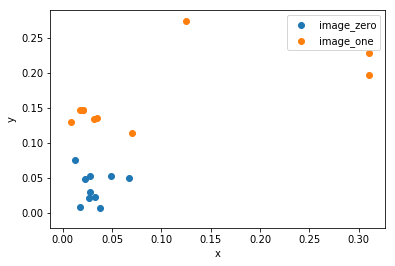

In [8]:
plt.scatter(zeros_coeffs[:,0], zeros_coeffs[:,1], label='image_zero')
plt.scatter(ones_coeffs[:,0], ones_coeffs[:,1], label='image_one')
plt.xlabel('x')
plt.ylabel('y')
plt.legend();

We can see from the above plot that excluding some outliers, the fourier coefficients are nicely clustered. Before investigating the outliers, we perform an opening and thresholding in the input images, to remove some of the noise, improve contour detection, and investigate whether this preprocessing will help increase the distance between clusters. 

In [9]:
def morph_transform(img):
    """
    Performs an opening and thresholding in the input images to remove some of the noise
    """
    kern = cv.getStructuringElement(cv.MORPH_ELLIPSE,(2,2))
    #opening = ndimage.grey_opening(img,size = (2,2))
    opening = cv.morphologyEx(img, cv.MORPH_OPEN, kern)
    ret,thresh = cv.threshold(opening,50,255,cv.THRESH_BINARY)
    return thresh

In [10]:
# Perform the morphological transform
morphed_zeros = np.array(map(lambda im:morph_transform(im),zeros_im))
morphed_ones = np.array(map(lambda im:morph_transform(im),ones_im))

In [11]:
# Find the descriptors
morph_zeros_coeffs = np.array(map(lambda im:findDescriptor(im),morphed_zeros))
morph_ones_coeffs = np.array(map(lambda im: findDescriptor(im),morphed_ones))

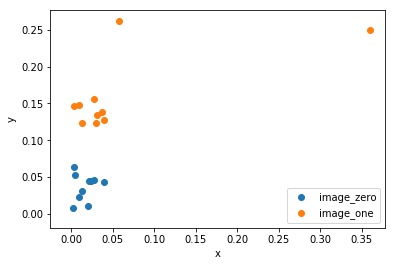

In [12]:
plt.scatter(morph_zeros_coeffs[:,0], morph_zeros_coeffs[:,1], label='image_zero')
plt.scatter(morph_ones_coeffs[:,0],morph_ones_coeffs[:,1], label='image_one')
plt.xlabel('x')
plt.ylabel('y')
plt.legend();

From the image above, we observe that the zeros(ones) are now closer to one another. Hence, performing an opening and thresholding on the image and then normalizing the fourier coefficients has improved our algorithm. However, the outliers still remain. Below, we investigate why these outliers appear.

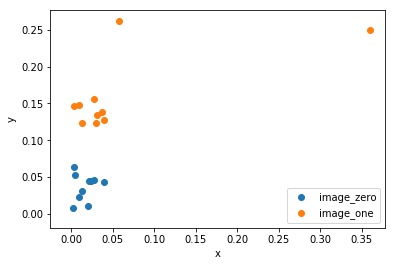

In [13]:
plt.scatter(morph_zeros_coeffs[:,0], morph_zeros_coeffs[:,1], label='image_zero')
plt.scatter(morph_ones_coeffs[:,0],morph_ones_coeffs[:,1], label='image_one')
plt.xlabel('x')
plt.ylabel('y')
plt.legend();

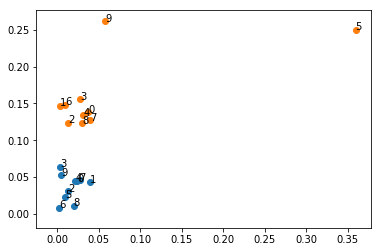

In [14]:
fig, ax = plt.subplots()
ax.scatter(morph_zeros_coeffs[:,0], morph_zeros_coeffs[:,1], label='image_zero')
ax.scatter(morph_ones_coeffs[:,0],morph_ones_coeffs[:,1], label='image_one')


for i in range(len(morph_zeros_coeffs)):
    ax.annotate(i, (morph_zeros_coeffs[i,0], morph_zeros_coeffs[i,1]))

for i in range(len(morph_ones_coeffs)):
    ax.annotate(i, (morph_ones_coeffs[i,0], morph_ones_coeffs[i,1]))

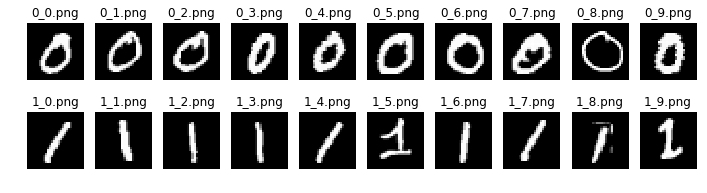

In [15]:
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_im, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

We see that the outliers correspond to the 6th and 10th image. In the images above, we notice that the ones in the 6th and 10th image are quite different from the ones in the rest of the images, because they have a lower tail which is missing in the other ones. Hence, we conclude that the outliers result from a difference in the input images rather than from an incorrect algorithm

We now proceed to increasing the input sample size, by rotating our current input and investigating whether the Fourier descriptors are invariant to rotation. We rotate each image by 90, 180, 270 degrees, so we triple the size of our input

In [16]:
def rotate_images(im):
    im_90 = transform.rotate(im,90,preserve_range = True)
    im_180 = transform.rotate(im,180,preserve_range = True)
    im_270 = transform.rotate(im,270,preserve_range = True)
    return [im,im_90,im_180,im_270]

In [17]:
extended_zeros,extended_ones = [],[]
for im in zeros_im:
    extended_zeros.extend(rotate_images(im))
for im in ones_im:
    extended_ones.extend(rotate_images(im))

In [18]:
# Perform the morphological transform
morphed_zeros = np.array(map(lambda im:morph_transform(im),extended_zeros))
morphed_ones = np.array(map(lambda im:morph_transform(im),extended_ones))
morph_zeros_coeffs = np.array(map(lambda im:findDescriptor(im),morphed_zeros))
morph_ones_coeffs = np.array(map(lambda im: findDescriptor(im),morphed_ones))

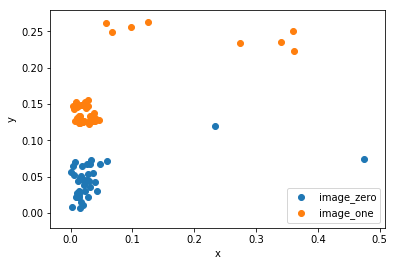

In [19]:
plt.scatter(morph_zeros_coeffs[:,0], morph_zeros_coeffs[:,1], label='image_zero')
plt.scatter(morph_ones_coeffs[:,0],morph_ones_coeffs[:,1], label='image_one')
plt.xlabel('x')
plt.ylabel('y')
plt.legend();

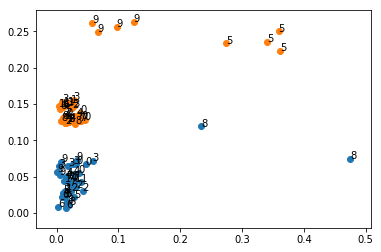

In [20]:
fig, ax = plt.subplots()
ax.scatter(morph_zeros_coeffs[:,0], morph_zeros_coeffs[:,1], label='image_zero')
ax.scatter(morph_ones_coeffs[:,0],morph_ones_coeffs[:,1], label='image_one')


for i in range(len(morph_zeros_coeffs)):
    ax.annotate(i//4, (morph_zeros_coeffs[i,0], morph_zeros_coeffs[i,1]))

for i in range(len(morph_ones_coeffs)):
    ax.annotate(i//4, (morph_ones_coeffs[i,0], morph_ones_coeffs[i,1]))

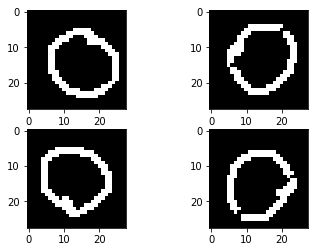

In [21]:
fig,axes = plt.subplots(2,2)
for i in range(4):
    axes[i/2][i%2].imshow(morphed_zeros[32+i],cmap = 'gray')

We observe that clustering still works quite well. However, we have two new outliers resulting from the rotating 9th image of 0. From the above pictures, we investigate that the reason behind the two new outliers is our morphological transform function, which creates a gap among two of the contours. However, we found out that changing the parameters of our morphological opening would decrease the performance of our algorithm for the other images, so we decided to keep the paramaters the same.

# 1.3 Additional Methods

We now try to use the edit distance method to compute the similarity between the contours of the image. The idea behind this algorithm is that we follow the contour along 8 directions, north, east, west, south, northeast, northwest, southeast and southwest, and label each direction we take with a number (1-8). We then create a string with the direction we take at each point until we reach the starting point using a breadth-first search.

In [22]:
def editDistance(s1,s2):
    """
    Finds the shorted distance between 2 strings 
    """
    dp = {}
    m = len(s1)+1 
    n = len(s2)+1
    for i in range(n):
        dp[0,i] = i
    for i in range(m):
        dp[i,0] = i
    
    for i in range(1,m):
        for j in range(1,n):
            if s1[i-1] == s2[j-1]:
                dp[i,j] = dp[i-1,j-1]
            else:
                dp[i,j] = 1 + min(dp[i,j-1],dp[i-1,j],dp[i-1,j-1])
    
    return dp[i,j]

In [55]:
def contour_to_string(img):
    dirs_map = {(-1,-1):'1',(-1,0):'2',(-1,1):'3',(0,-1):'4',(0,1):'5',(1,-1):'6',(1,0):'7',(1,1):'8'}
    dir_x = [-1,0,1,-1,1,-1,0,1]    
    dir_y = [-1,-1,-1,0,0,1,1,1]
    # Find starting point
    start_point = (0,0)
    
    for  i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if img[i,j]  != 0:
                start_point = (i,j)
                break
    
    
    queue = []
    visited = []
    string_dir = ''
    queue.append(start_point)
    iteration = 0
    while(len(queue) > 0):
        cur_point = queue.pop(0)
        if cur_point in visited:
            continue
        visited.append(cur_point)
        
        for k in range(len(dir_x)):
            #print('x = {0} and y = {1}'.format(x,y))
            new_point = (cur_point[0]+dir_x[k],cur_point[1]+dir_y[k])
            if new_point[0] >= img.shape[0] or new_point[1] >= img.shape[1]:
                continue
            
            if img[new_point[0],new_point[1]] == 0:
                continue
            queue.append(new_point)
            string_dir+=dirs_map[(dir_x[k],dir_y[k])]
        
        # Break if the lengths of the strings exceed 200
        # Otherwise string could end up being more than 10000 characters long
        if len(string_dir) > 2000:
            break
    return string_dir

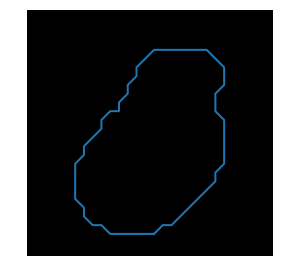

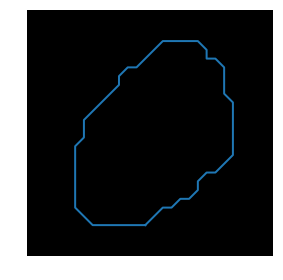

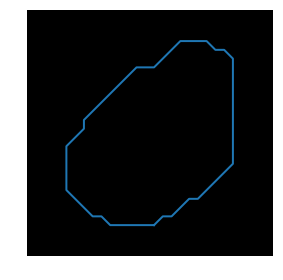

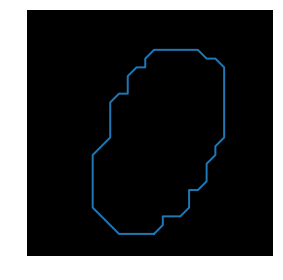

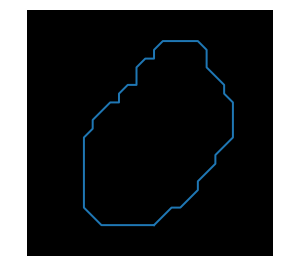

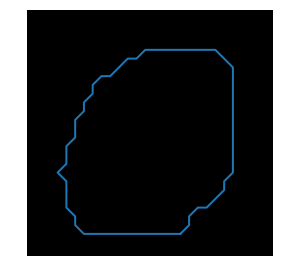

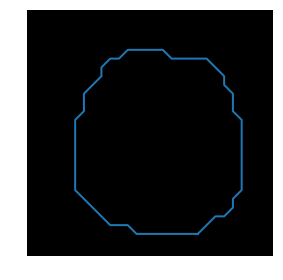

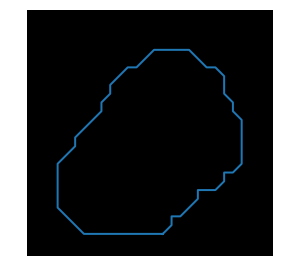

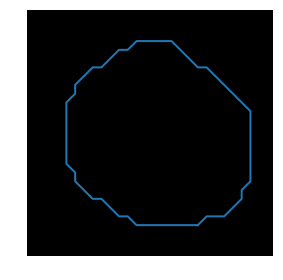

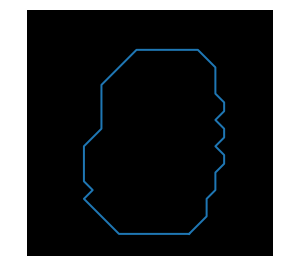

In [25]:
# Get only the contour images of zeros
contour_zeros = list(map(lambda im: contours_only(im),zeros_im))

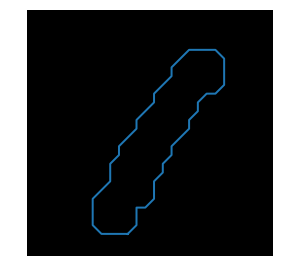

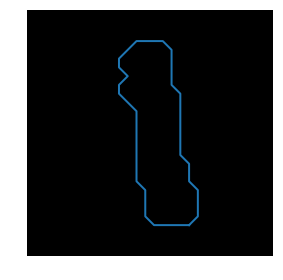

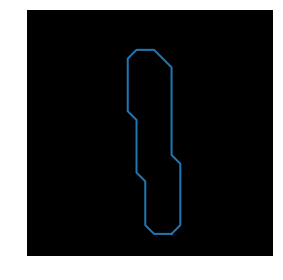

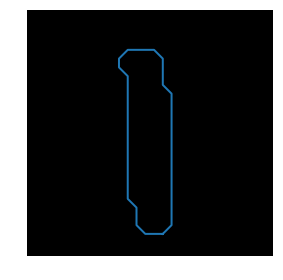

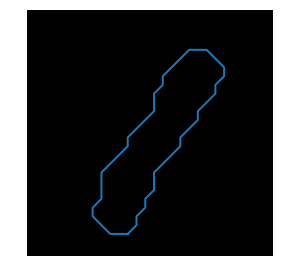

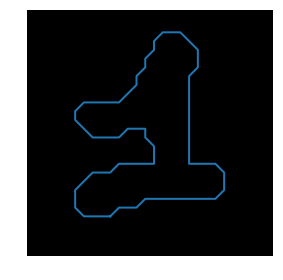

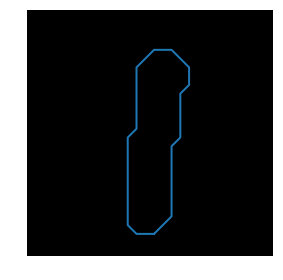

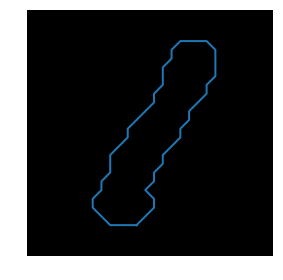

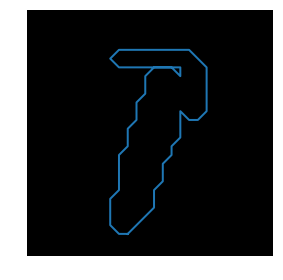

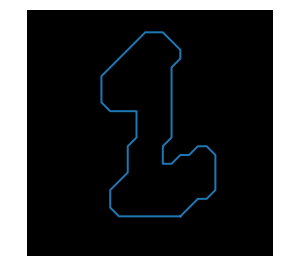

In [26]:
# Get only the contour images of ones
contour_ones = list(map(lambda im: contours_only(im),ones_im))

In [27]:
test_cnt = contour_zeros[0]

In [28]:
%%time
res = contour_to_string(test_cnt)

CPU times: user 138 ms, sys: 77.3 ms, total: 216 ms
Wall time: 69.4 ms


We tested our breadth-first search algorithm with the first contour image, and we found that its execution time for the first contour image was 314 ms wall time and the above result is the shortest path it takes to explore the whole contour.

We now use the edit distance algorithm. The algorithm will work in the following manner:
-  We select an arbitrary reference image ( It will be changed if we later find that our algorithm performs better with another reference image)
-  We build a string for the shortest path it takes to explore the whole contour
-  Then, for every other image we do the same
-  Use the edit distance algorithm to compare the string of each image with the string of the reference image

In [51]:
dir_strings = list(map(lambda im:contour_to_string(im),contour_zeros[1:]))
tmp = list(map(lambda im:contour_to_string(im),contour_ones))
dir_strings.extend(tmp)

In [52]:
reference_string = contour_to_string(contour_zeros[0])

In [53]:
print(len(reference_string))

2003


In [54]:
for i,dir_str in enumerate(dir_strings):
    if i == 9:
        print('-----------------')
    print(editDistance(reference_string,dir_str))

331
200
410
317
392
320
393
191
405
-----------------
424
448
383
414
400
394
400
499
508
363


From the above result, we notice that if we set the threshold to 400, we would have 2 false negatives and 3 false positives. Hence, the precision in this case would be $\frac{15}{18} \approx 83\%$ and the recall is $\frac{15}{17} \approx 88\%$

Our initial approach was to use BFS to describe the contour, since it is guaranteed that BFS finds the shortest path. However, we noticed that the precision was relatively low and it took a considerable amount of iterations to have a good thresholds to separate ones and zeros. Hence, we decided to use the idea of Freeman chain codes to build a representation of the contours. 
The basic principle of chain codes is to separately encode each connected component, or "blob", in the image.
For each such region, a point on the boundary is selected and its coordinates are transmitted. The encoder then moves along the boundary of the region and, at each step, transmits a symbol representing the direction of this movement.

In [73]:
directions = [0,1,2,7,3,6,5,4]
dir2idx = dict(zip(directions, range(len(directions))))
print(directions)

[0, 1, 2, 7, 3, 6, 5, 4]


In [74]:
def chain_rule(image):
    ret,img = cv.threshold(image,70,255,0)
    
   # Find the coordinates of the first point 
    for i, row in enumerate(img):
        for j, value in enumerate(row):
            if value == 255:
                start_point = (i, j)
                break
        else:
            continue
        break
        
    # direction of movement: W, NW, N, SW, NE, S, SE, E
    directions = [0,1,2,7,3,6,5,4]
    
    # Create pairing: 0->0, 1->1, 2-> 2, 7->3, 3->4, 6->5, 5->6, 4-> 7
    dir2idx = dict(zip(directions, range(len(directions))))
    
    dir_y = [-1,0,1,-1,1,-1,0,1]
    dir_x = [-1,-1,-1,0,0,1,1,1]


    border = []
    chain = ''
    curr_point = start_point
    for direction in directions:
        idx = dir2idx[direction]
        new_point = (start_point[0]+dir_x[idx], start_point[1]+dir_y[idx])
        if img[new_point] != 0: # Find a contour point
            border.append(new_point)
            chain += str(direction)
            curr_point = new_point
            break

    count = 0
    while curr_point != start_point:
        #figure direction to start search
        b_direction = (direction + 5) % 8 
        dirs = range(b_direction, 8)
        tmp = range(0, b_direction)
        dirs.extend(tmp)
        for direction in dirs:
            idx = dir2idx[direction]
            new_point = (curr_point[0]+dir_x[idx], curr_point[1]+dir_y[idx])
            if image[new_point] != 0: # If point is in the contour
                border.append(new_point)
                chain+=str(direction)
                curr_point = new_point
                break
        if count == 1000: break
        count += 1
    return chain

In [75]:
reference_chain = chain_rule(contour_zeros[0])

In [76]:
chains = list(map(lambda im:chain_rule(im),contour_zeros[1:]))
tmp = list(map(lambda im:chain_rule(im),contour_ones))
chains.extend(tmp)

In [77]:
for i,ch in enumerate(chains):
    if i==9:
        print('---------------------')
    print(editDistance(ch,reference_chain))

167
132
172
154
163
169
165
187
167
---------------------
205
209
238
229
214
494
211
202
231
494


We notice that with Freeman chain codes, we get a nice separation of the numbers, where the edit distance of the string representation of two zeros gives an output less than 200 while the edit distance of the string representation of a zero and a one gives an output that is greater than 200.